<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20CNN%20epilepsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://physionet.org/content/chbmit/1.0.0/chb01/#files-panel

In [19]:
!pip install pywavelets
!pip install mne
!pip install pyedflib pywt matplotlib
!pip install pyedflib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mne
import pywt
import pyedflib
import pylab
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import re
from scipy import signal
from scipy.fft import fft, fftfreq

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#подключаем (монтируем) к ноутубуку свой гугл-диск

from google.colab import drive
drive.mount('/content/drive')
import os
from os import listdir

#обратите внимание - надо указать путь до своей папки на гугл-диске
os.chdir('/content/drive/MyDrive/edf_process/CNN_NN_learning')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        signals = np.zeros((n, f.getNSamples()[0]))
        for i in range(n):
            signals[i, :] = f.readSignal(i)
    return signals, signal_labels

In [ ]:
def save_wavelet_transform(signal, file_name, output_dir, start_time, end_time, sampling_rate, time_label):

    #scales = np.logspace(np.log10(scale_min), np.log10(scale_max), num = 25, endpoint=True, base=10.0)
    scale_max = [200, 50, 26, 14, 6]
    scale_min = [50, 26, 14, 6, 3.5]
    wavelet_core = 'morl'
    dt = 1 / sampling_rate
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    #plt.figure(figsize = (10, 10))
    #plt.title(f'Wavelet Transform of {file_name}')
    #plt.axis('off')
    v_max = [240, 120, 40, 30, 20]
    # ax.set_title(f'Wavelet Transform of {file_name}')
    for k in range(len(signal)):
            scales = np.linspace(scale_min[k], scale_max[k], num=25, endpoint=True)
            coef, freqs = pywt.cwt(signal[k], scales, wavelet_core, sampling_period=dt)
            frequencies = pywt.scale2frequency(wavelet_core, scales) / dt
            # изобразим график зависимости частоты и масштаба
            # plt.figure(figsize=(7, 7))
            # plt.grid()
            # plt.yticks(np.arange(min(freqs), max(freqs), (max(freqs) - min(freqs))/10))
            # plt.xticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
            # plt.ylabel('Частота[Герц]', fontsize=12)
            # plt.xlabel('масштаб в вейвлет преобразовании', fontsize=12)
            # plt.plot(scales, freqs,'.-')

            # Создаем кастомную цветовую карту от синего до красного с пределами мощности от 0 до 20
            colors = [(0, 'blue'), (0.5, 'cyan'), (0.9, 'yellow'), (1, 'darkred')]
            custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
            ax = plt.subplot(5, 1, k + 1)

            extent = [start_time, end_time, frequencies[-1], frequencies[0]]  # Устанавливаем частоту на вертикальной оси
            # Используем фиксированные пределы vmin=0 и vmax=20
            img = ax.imshow(np.abs(coef), extent=extent, cmap=custom_cmap, aspect='auto', vmin=0, vmax=v_max[k])
            # plt.colorbar(label='Magnitude')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_xlabel('Time (seconds)')
            # plt.axis('off')
            ax.set_ylim(frequencies[-1], frequencies[0])

            # Сохранение изображения
    output_path = os.path.join(output_dir, f'{file_name}_{time_label}_wavelet.png')
    plt.savefig(output_path)
    plt.show()
    plt.close()
    return output_path

In [ ]:
def parse_summary_file(summary_file_path):
    edf_files = []
    with open(summary_file_path, 'r') as file:
        content = file.read()
        files = re.split(r'File Name: ', content)[1:]  # Разделение по файлам
        for file_info in files:
            lines = file_info.split('\n')
            file_name = lines[0].strip()
            seizure_start = []
            seizure_end = []
            num_seizures = 0
            k=0
            for line in lines[1:]:
                if 'Number of Seizures in File' in line:
                    num_seizures = int(line.split(':')[-1].strip())
                    k=num_seizures
                    continue

                if k > 0:
                    if ('Seizure' in line)and('Start Time' in line):
                        seizure_start_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_start.append(seizure_start_i)
                        continue

                    if ('Seizure' in line)and('End Time' in line):
                        seizure_end_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_end.append(seizure_end_i)
                        k-=1
                        continue

            edf_files.append({
                'file_name': file_name,
                'seizure_start': seizure_start,
                'seizure_end': seizure_end,
                'num_seizures': num_seizures
            })
    return edf_files


In [ ]:
#процедура для фильтрации (выделению) из всего сигнала диапазонов частот
def butter_bandpass_filter(data, fs, plot_signal=False, order=5):
    # Определение диапазонов фильтрации
    lowcut = [1, 4, 8, 14, 30]
    highcut = [4, 8, 14, 20, 50]
    nyquist = 0.5 * fs
    # Список для хранения отфильтрованных сигналов
    filtered_signals = []
    # Фильтрация для каждого диапазона частот
    for i in range(len(lowcut)):
        low = lowcut[i] / nyquist
        high = highcut[i] / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data = signal.lfilter(b, a, data)
        filtered_signals.append(filtered_data)
    # Построение спектров
    #plt.figure(figsize=(7, 5))
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    for i, filtered_data in enumerate(filtered_signals):
        # Преобразование Фурье
        signal_fft = fft(filtered_data)
        # Амплитуды и частоты
        amplitudes = np.abs(signal_fft) / len(filtered_data)
        frequencies = fftfreq(len(filtered_data), 1 / fs)

        # Отбираем только положительные частоты
        positive_freqs = frequencies > 0
        frequencies = frequencies[positive_freqs]
        amplitudes = amplitudes[positive_freqs]

        # Построение графика спектра
        # Построение спектра
        #if plot_signal:
        #        plt.plot(frequencies, amplitudes, label = leg[i])
        #        plt.xlim([0, 60])
        #        plt.title("Спектр сигнала")
        #        plt.xlabel("Частота (Гц)")
        #        plt.ylabel("Амплитуда")
    #if plot_signal:
    #  plt.legend(loc='best')
    #  plt.tight_layout()
    #  plt.grid(which='minor')
    #  plt.show()

    return filtered_signals

In [ ]:
# процедура выделения из всего сигнала окна для выгрузки части сионала
def measured(signal,window_size,sampling_time):
    window_size = int(window_size * sampling_time)
    a = 0
    b = window_size
    n = signal.size/window_size
    f_signal = np.copy(signal)
    for i in range(int(n)):
        a = i*window_size
        b = (i+1)*window_size
        f_signal[a:b] = signal[a:b] - np.mean(signal[a:b])
    return f_signal

# процедура осреднения сигнала - убираем постоянную составляющую
def mean_delete(filtered_alpha,window_count,sampling_rate,time,plot_signal=False):
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    leg2 = ["Delta_m", "Theta_m","Alpha_m", "Beta_m","Gamma_m"]
    processed_signals = []
    plt.figure(figsize =(15,7))
    fig, axes = plt.subplots(5, 1, figsize=(12, 12))
    for i in range(5):
        filtered_1 = filtered_alpha[i]
        filtered_2 = measured(filtered_1,window_count,sampling_rate)
        processed_signals.append(filtered_2)
        if plot_signal:
          pylab.subplot (5, 1, i+1)
          plt.plot(time, filtered_1, label = leg[i])
          plt.plot(time, filtered_2, label = leg2[i])
          plt.legend(loc = "best")
          plt.xlim([2310, 2311])

    return processed_signals

# Make Dataset from EDF file

In [ ]:
# Директория для сохранения изображений на Google Диске
output_dir = os.path.join(os.getcwd(), 'wavelet_img')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# количество записей EDF
amount_of_rawedf = 24
os.chdir('/content')
!ls

drive  physionet.org  sample_data


--2024-12-01 21:09:35--  https://physionet.org/files/chbmit/1.0.0/chb02/chb02-summary.txt
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4471 (4.4K) [text/plain]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb02/chb02-summary.txt’

physionet.org/files 100%[===================>]   4.37K  --.-KB/s    in 0s      

2024-12-01 21:09:36 (788 MB/s) - ‘physionet.org/files/chbmit/1.0.0/chb02/chb02-summary.txt’ saved [4471/4471]

FINISHED --2024-12-01 21:09:36--
Total wall clock time: 1.2s
Downloaded: 1 files, 4.4K in 0s (788 MB/s)
--2024-12-01 21:09:36--  https://physionet.org/files/chbmit/1.0.0/chb02/chb02_01.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘physionet

<Figure size 1500x700 with 0 Axes>

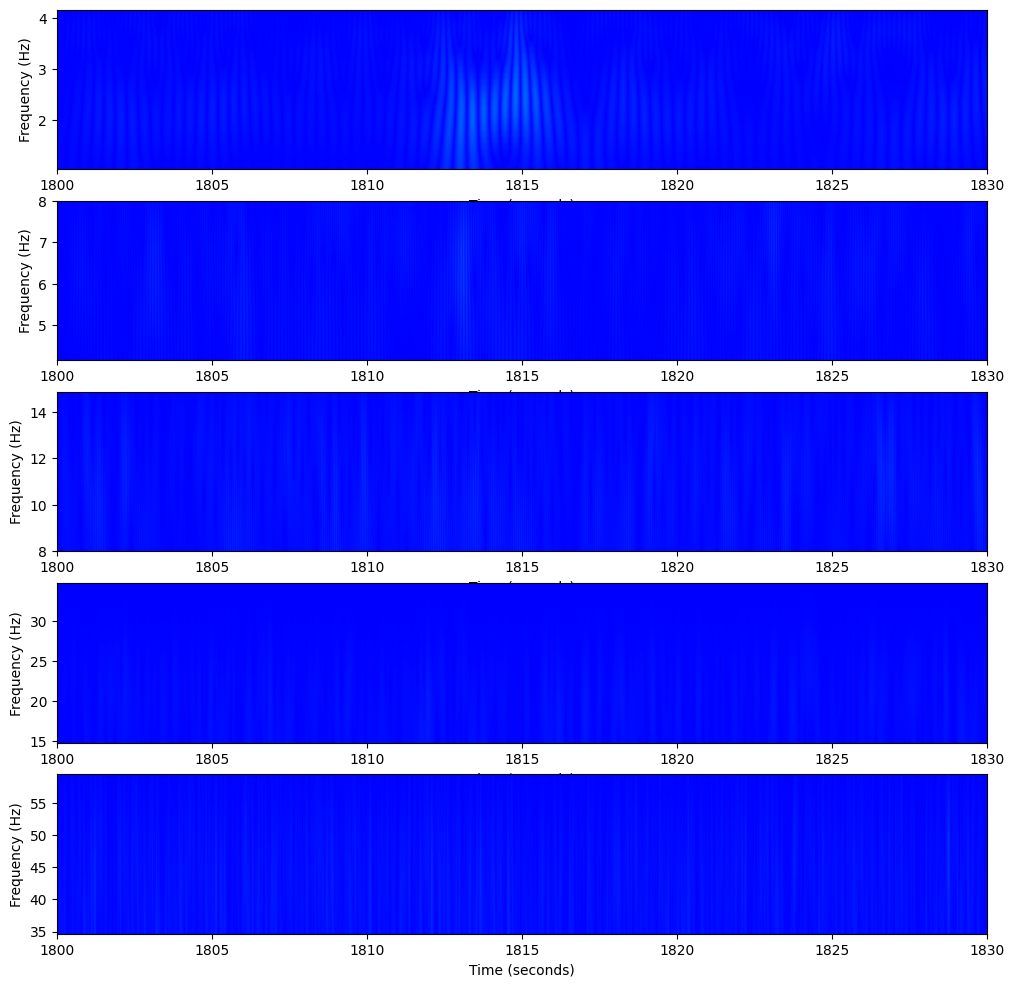

--2024-12-01 21:11:05--  https://physionet.org/files/chbmit/1.0.0/chb02/chb02_02.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_02.edf’

physionet.org/files 100%[===================>]  40.44M   505KB/s    in 83s     

2024-12-01 21:12:29 (499 KB/s) - ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_02.edf’ saved [42399744/42399744]

FINISHED --2024-12-01 21:12:29--
Total wall clock time: 1m 24s
Downloaded: 1 files, 40M in 1m 23s (499 KB/s)


<Figure size 1500x700 with 0 Axes>

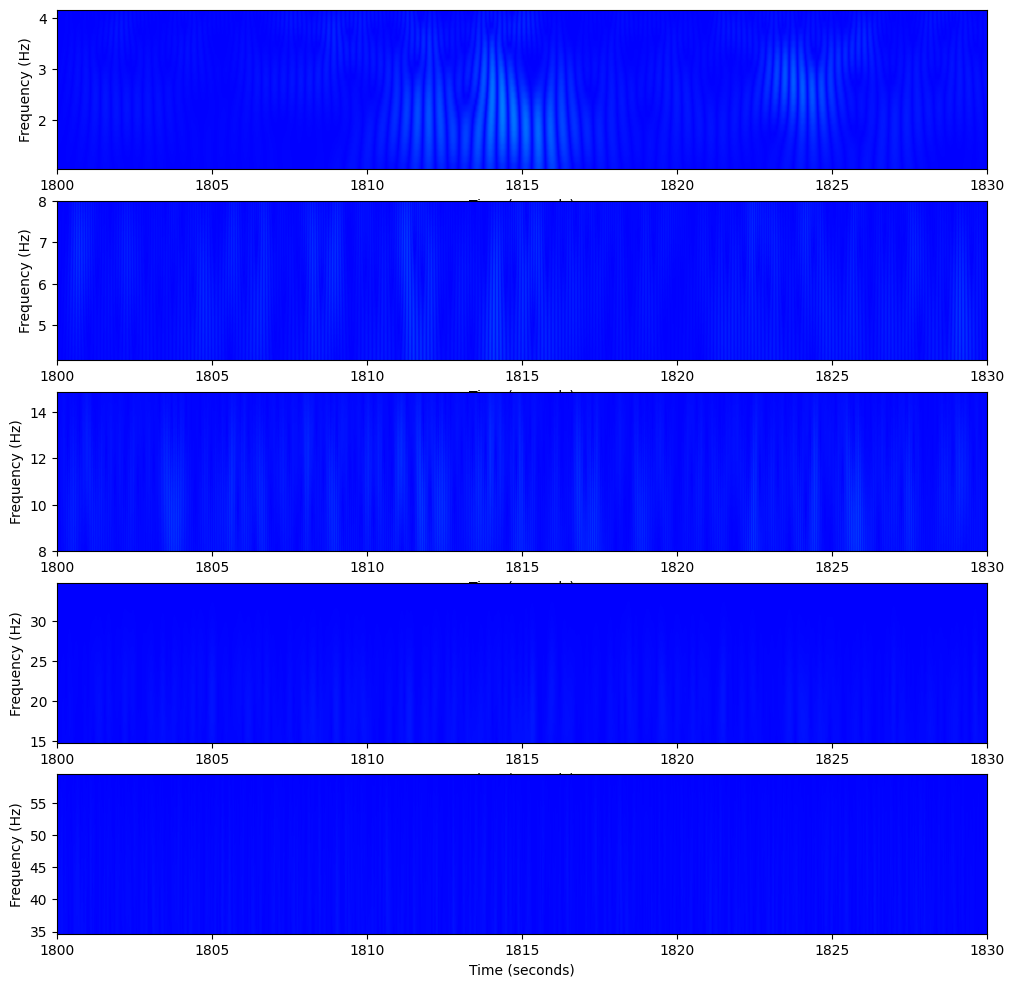

--2024-12-01 21:12:33--  https://physionet.org/files/chbmit/1.0.0/chb02/chb02_03.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_03.edf’

physionet.org/files 100%[===================>]  40.44M   476KB/s    in 87s     

2024-12-01 21:14:02 (475 KB/s) - ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_03.edf’ saved [42399744/42399744]

FINISHED --2024-12-01 21:14:02--
Total wall clock time: 1m 28s
Downloaded: 1 files, 40M in 1m 27s (475 KB/s)


<Figure size 1500x700 with 0 Axes>

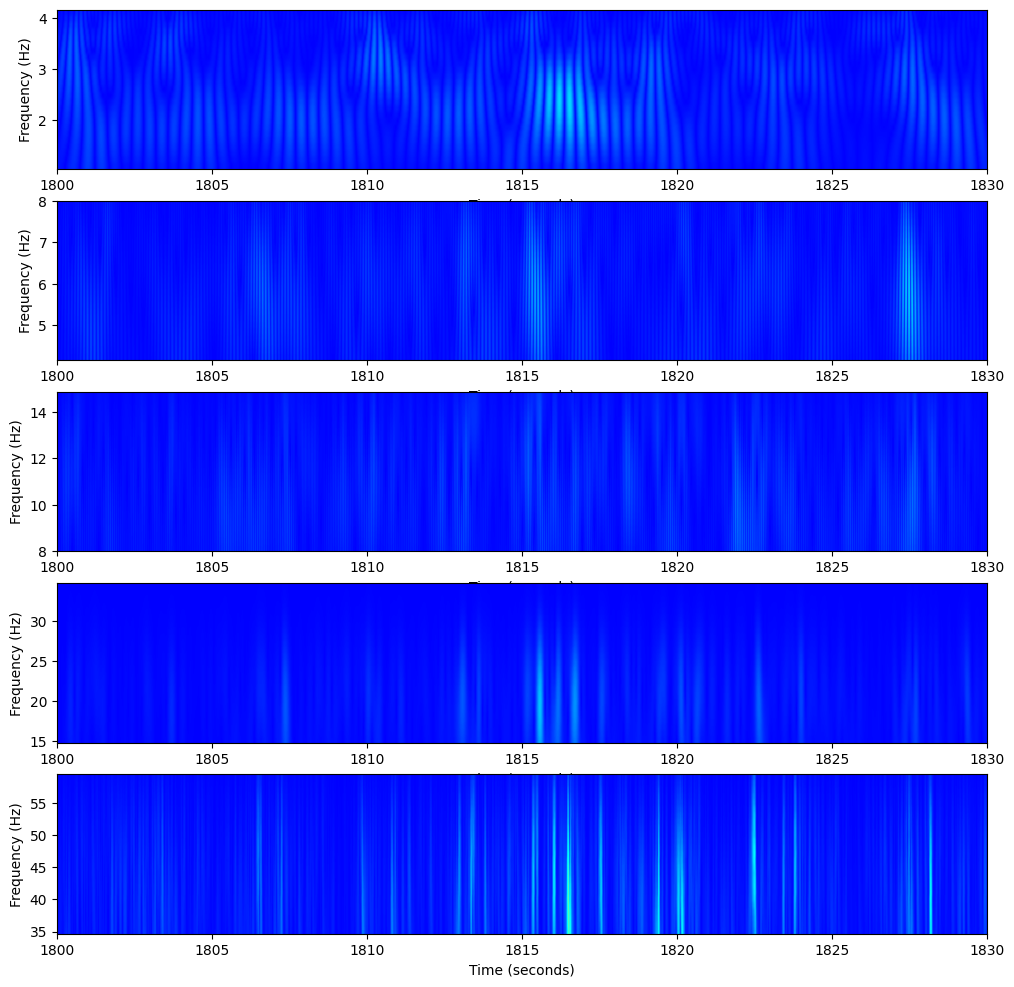

--2024-12-01 21:14:06--  https://physionet.org/files/chbmit/1.0.0/chb02/chb02_04.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_04.edf’

physionet.org/files 100%[===================>]  40.44M   504KB/s    in 84s     

2024-12-01 21:15:32 (492 KB/s) - ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_04.edf’ saved [42399744/42399744]

FINISHED --2024-12-01 21:15:32--
Total wall clock time: 1m 25s
Downloaded: 1 files, 40M in 1m 24s (492 KB/s)


<Figure size 1500x700 with 0 Axes>

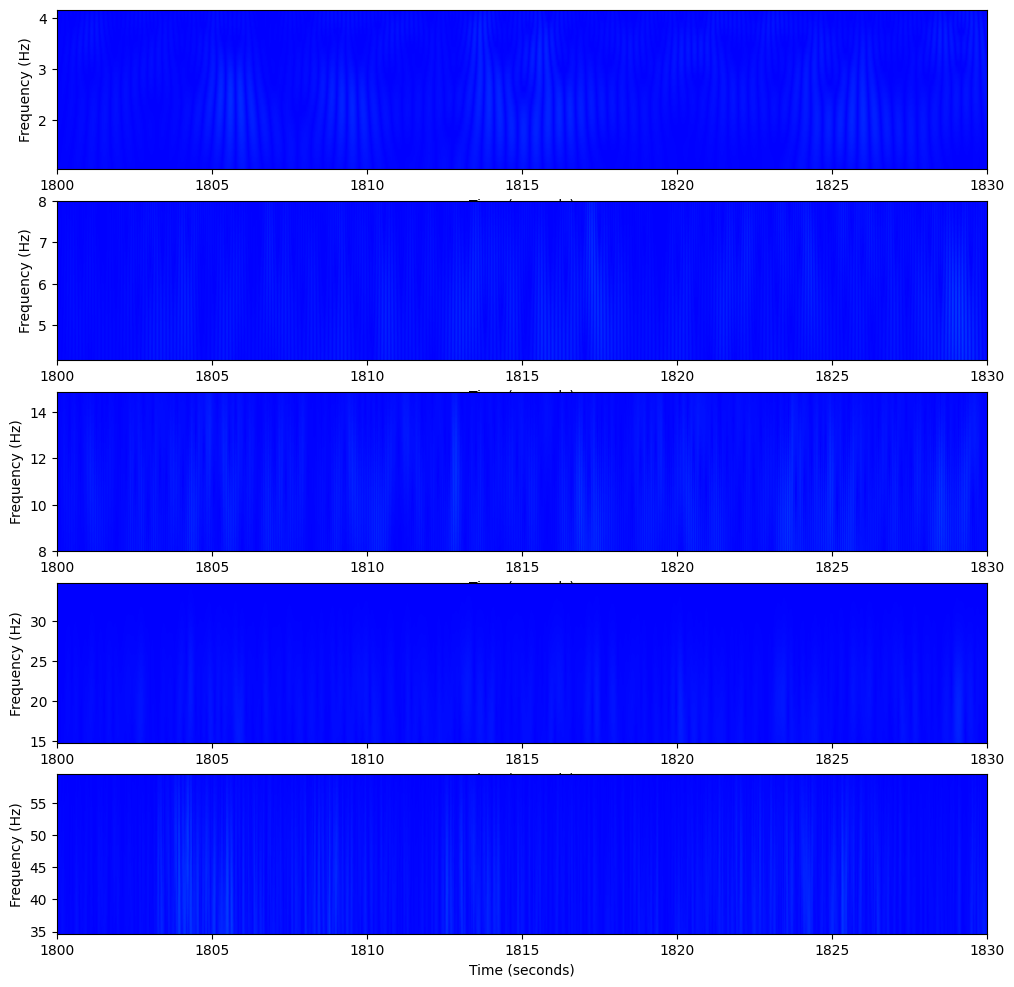

--2024-12-01 21:15:36--  https://physionet.org/files/chbmit/1.0.0/chb02/chb02_05.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_05.edf’

physionet.org/files 100%[===================>]  40.44M   498KB/s    in 83s     

2024-12-01 21:17:00 (501 KB/s) - ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_05.edf’ saved [42399744/42399744]

FINISHED --2024-12-01 21:17:00--
Total wall clock time: 1m 24s
Downloaded: 1 files, 40M in 1m 23s (501 KB/s)


<Figure size 1500x700 with 0 Axes>

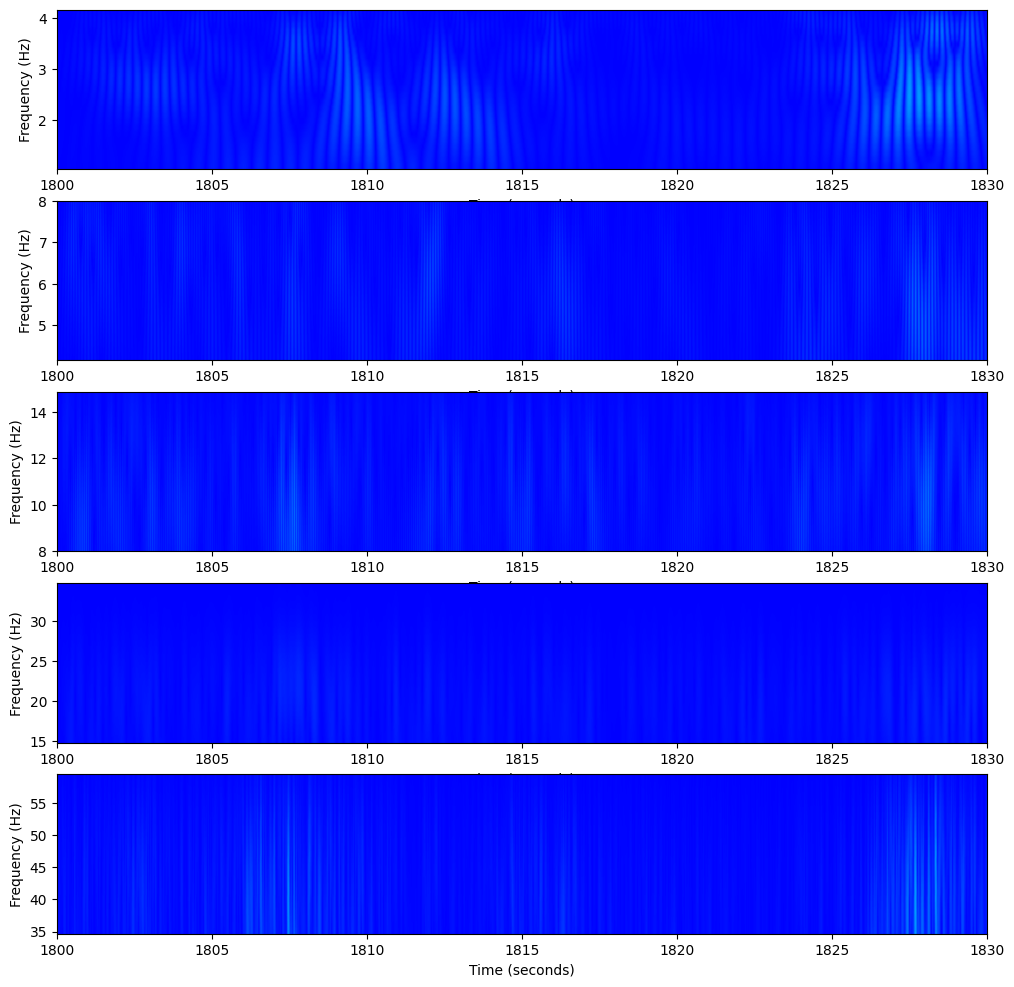

--2024-12-01 21:17:04--  https://physionet.org/files/chbmit/1.0.0/chb02/chb02_06.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb02/chb02_06.edf’

6.edf                53%[=========>          ]  21.80M   499KB/s    eta 37s    

In [ ]:
for spisok in range(1,2,1):
  os.chdir('/content')
  #задаем путь до файла с описание ЭЭГ
  summary_file_path = '/physionet.org/files/chbmit/1.0.0/chb0%d/chb0%d-summary.txt' % (spisok+1, spisok+1)
  physionet_summary_file_url = 'https:/'+summary_file_path
  #зaкачиваем в ноутбук файл описание ЭЭГ
  !wget -r -c -N --no-parent -np $physionet_summary_file_url
  #распарсиваем записи из файла с описанием ЭЭГ на массив данных
  edf_files_list = parse_summary_file('/content'+summary_file_path)


  #edf_directory = os.chdir('/content/drive/MyDrive/edf_process/CNN_NN_learning')
  sampling_rate = 256
  window_count = 0.5
  flag = 0

  #основной цикл превращения EDF в изображение
  for edf_file in edf_files_list:
    os.chdir('/content')
    edf_directory = '/physionet.org/files/chbmit/1.0.0/chb0%d/' % (spisok+1)
    edf_file_link = f"{'https:/'}{edf_directory}{edf_file['file_name']}"
    #загружаем EDF в ноутбук
    !wget -r -c -N -np $edf_file_link

    #записывам сигналы и метки ЭЭГ в переменные
    edf_file_path = f"{'/content'}{edf_directory}{edf_file['file_name']}"
    signals, labels = read_edf(edf_file_path)

    # Если есть приступ, генерируем изображения для 3 временных интервалов
    if len(edf_file['seizure_start']) != 0:
      flag = 1
      seizure_times = [(30, '30_sec_before'), (30, '60_sec_before'), (30, '90_sec_before')]
      number = 1
      for seiz_time in range(len(edf_file['seizure_start'])):
        seizure_st = edf_file['seizure_start'][seiz_time]
        seizure_en = edf_file['seizure_end'][seiz_time]
        for time_offset, time_label in seizure_times:
          time_window_start = seizure_st - time_offset
          time_window_end = seizure_st  # Окно в 30 секунд
          seizure_st = seizure_st- 30
          time_window_start_samples = time_window_start * sampling_rate
          time_window_end_samples = time_window_end * sampling_rate
          signal_s = np.delete(signals, [len(signals)-1], axis=0)
          time = np.arange(time_window_start, time_window_end, 1/sampling_rate)

          # Усреднение сигналов
          avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
          for i in range(len(signals)-1):
            avg_signal += signal_s[i, time_window_start_samples:time_window_end_samples]
          avg_signal /= len(signals)

          # Применение фильтра Баттерворта
          filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
          filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time,plot_signal=False)

          # Определяем директорию и путь для сохранения изображения
          os.chdir('/content/drive/MyDrive/edf_process/CNN_NN_learning/wavelet_img')
          save_dir = os.path.join(output_dir, 'Seizure')
          os.makedirs(save_dir, exist_ok=True)

          # Сохранение изображения
          image_path = f"{edf_file['file_name']}_{time_label}_{number}_wavelet.png"
          save_wavelet_transform(filtered_mean, image_path, save_dir,
                                            time_window_start, time_window_end, sampling_rate,time_label)
          number+=1
    else:
      # Обработка для записей без приступа (Healthy)
      flag = 0
      #приступов нет, поэтому выбираем любое значение времени для выгрузки ЭЭГ
      #time_window_start = 2300
      time_window_start = int(signals.shape[1]/sampling_rate/2)
      #time_window_end = 2330
      time_label = 30 #ширина окна для выгрузки данных
      time_window_end = time_window_start + time_label

      time_window_start_samples = time_window_start * sampling_rate
      time_window_end_samples = time_window_end * sampling_rate
      signals = np.delete(signals, [len(signals)-1], axis=0)
      time = np.arange(time_window_start, time_window_end, 1/sampling_rate)
      # Усреднение сигналов
      avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
      for i in range(len(signals)-1):
        # Проходим по всем каналам
        avg_signal += signals[i, time_window_start_samples:time_window_end_samples]
        avg_signal /= len(signals)  # Среднее значение по всем каналам
      #for s in signals:
      #  plt.plot(time, s[time_window_start_samples:time_window_end_samples])
      #plt.plot(time,  avg_signal, label = 'Усредненный сигнал')
      #plt.legend(loc = 'best')
      #plt.xlabel("Время, [с]")
      #plt.ylabel("Амплитуда")
      #plt.savefig(output_dir)

      # Фильр Баттерворта
      filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
      #i = 0
      #plt.figure(figsize =(15,7))
      #leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
      #fig, axes = plt.subplots(5, 1, figsize=(12, 12))
      #for s in filtered_data:
      #  ax = plt.subplot(5, 1, i + 1)
      #  plt.plot(time, s, label=leg[i])
      #  plt.grid()
      #  plt.legend(loc = "best")
      #  i = i+1
      #plt.xlabel("Время, [с]")
      #spectr = os.path.join(output_dir, "spectr.png")
      #plt.savefig(spectr,bbox_inches='tight')
      # plt.ylabel("Амплитуда")
      #plt.close()

      # Удаление среднего скользящим окном
      filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time, plot_signal=False)

      # Определяем директорию и путь для сохранения изображения
      save_dir = os.path.join(output_dir, 'Healthy')
      os.makedirs(save_dir, exist_ok=True)
      #image_path = os.path.join(save_dir, f"{edf_file['file_name']}_{time_label}_wavelet.png")
      image_path = f"{edf_file['file_name']}_{time_label}_wavelet.png"

      # Сохранение изображения
      save_wavelet_transform(filtered_mean, image_path,
                                            save_dir,time_window_start,
                                            time_window_end, sampling_rate,time_label)
  import shutil
  shutil.rmtree('/content/physionet.org')

In [ ]:
!ls

drive  physionet.org  sample_data


In [22]:
import shutil
shutil.rmtree('/content/physionet.org')

# Convolution Neural Network Model

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight, shuffle
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

**Новая нейронка **

In [ ]:
# Функция для загрузки изображений
def load_images(image_dir, target_size):
    images = []
    labels = []
    for class_dir in ['Healthy', 'Seizure']:  # Подкаталоги классов
        class_path = os.path.join(image_dir, class_dir)
        label = 0 if class_dir == 'Healthy' else 1  # Классы кодируются как 0 или 1
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            # plt.figure()
            # plt.imshow(img)
            img = tf.image.resize(img, target_size)  # Изменение размеров изображения
            images.append(img)
            labels.append(label)
    plt.show()
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [ ]:
# Функция для вывода изображений с метками
def display_samples(X, y, num_samples, dataset_name="Dataset"):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        # plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i,:,:,:])
        plt.title(f"Label: {np.argmax(y[i])}")
        plt.axis('off')
    plt.suptitle(f"Sample images from {dataset_name}")
    plt.show()



In [ ]:
# Путь к директории с изображениями
image_dir = '/content/drive/MyDrive/edf_process/CNN_NN_learning/wavelet_img/'
os.chdir(image_dir)


# Загрузка данных
X, y = load_images(image_dir, (700,700))
# print(X[1,32,32,:])
# Масштабирование изображений (нормализация)
# X = X / 255.0
X, y = shuffle(X, y, random_state=24)
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Преобразование меток в категориальный формат (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:

# Вывод примеров из тестовой выборки
# Вывод примеров из обучающей выборки
display_samples(X_train, y_train, num_samples=25, dataset_name="Training Set")
display_samples(X_test, y_test, num_samples=25, dataset_name="Testing Set")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 700, 700, 64)        │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 700, 700, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 350, 350, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 350, 350, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 175, 175, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 175, 175, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 87, 87, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 87, 87, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1937664)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     248,021,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,532,738 (948.08 MB)

 Trainable params: 248,532,610 (948.08 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5708 - loss: 14.0936 - val_accuracy: 0.5750 - val_loss: 8.1082
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5621 - loss: 7.5352 - val_accuracy: 0.6500 - val_loss: 6.1250
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 909ms/step - accuracy: 0.5504 - loss: 5.8420 - val_accuracy: 0.5750 - val_loss: 5.2787
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 925ms/step - accuracy: 0.6461 - loss: 5.1981 - val_accuracy: 0.5750 - val_loss: 5.0674
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6832 - loss: 4.9792 - val_accuracy: 0.7250 - val_loss: 4.9400
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 950ms/step - accuracy: 0.7600 - loss: 4.8712 - val_accuracy: 0.5750 - val_loss: 4.7468
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 950ms/step - accuracy: 0.8238 - loss: 4.5312 - val_accuracy: 0.5750 - val_loss: 4.4873
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 945ms/step - accuracy: 0.8320 - loss: 4.2406 - val_accuracy: 0.

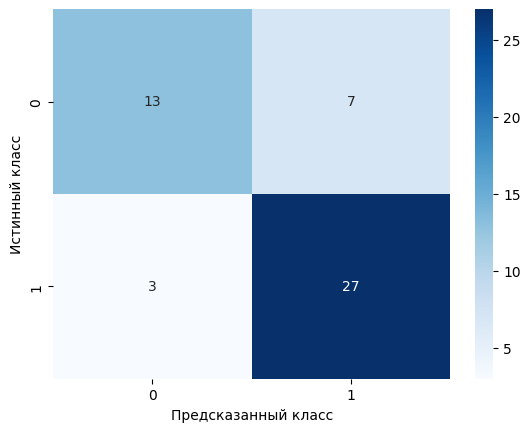

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Преобразование меток в категориальный формат (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
# Создание модели CNN-LSTM
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    Input(shape=(num_frames, height, width, channels)),
    # Cверточные слои
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.5))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))


    # Преобразование для LSTM
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))  # Регуляризация L2
    # model.add(Dropout(0.5))
    model.add(Reshape((1, -1)))  # Преобразуем в последовательность длины 1 для LSTM
    model.add(LSTM(128, return_sequences=False))  # Первый LSTM слой
    # model.add(Dropout(0.3))

    # Полносвязный слой
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))
    # model.add(Dropout(0.5))

    # Выходной слой для двух классов
    model.add(Dense(2, activation='sigmoid'))  # Для классификации на 2 класса

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Инициализация модели
input_shape = (700, 700, 4)  # Изображения 64x64 с 3 каналами (RGB)
model = create_cnn_lstm_model(input_shape)
model.summary()

# Обучение модели

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)
# Преобразование меток обратно из one-hot encoding в одномерный массив меток

y_train_classes = np.argmax(y_train, axis=1)

# Вычисление весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Преобразование class_weights в словарь, так как model.fit ожидает словарь
class_weights_dict = dict(enumerate(class_weights))
checkpoint = ModelCheckpoint(
    "best_weights.keras",  # Имя файла для сохранения весов
    monitor="val_accuracy",  # Метрика для отслеживания
    save_best_only=True,     # Сохранять только если улучшилась метрика
    mode="max",              # "max" для максимизации метрики
    verbose=1
)
# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2, class_weight=class_weights_dict )
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Печать результатов оценки
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))

# Построение матрицы ошибок
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()



In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model

# Параметры данных
num_frames =  3       # Число кадров на человека (временные шаги)
height, width, channels = 700, 700, 4  # Размеры кадра

# Вход для набора кадров
model = Sequential([
    Input(shape=(num_frames, height, width, channels)),
    TimeDistributed(Conv2D(32, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(Flatten()),
    LSTM(50),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.06)),
    Dense(2, activation='sigmoid')
]

)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Проверка модели
model.summary()
y_train_classes = np.argmax(y_train, axis=1)

# Вычисление весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Преобразование class_weights в словарь, так как model.fit ожидает словарь
class_weights_dict = dict(enumerate(class_weights))
checkpoint = ModelCheckpoint(
    "best_weights.keras",  # Имя файла для сохранения весов
    monitor="val_accuracy",  # Метрика для отслеживания
    save_best_only=True,     # Сохранять только если улучшилась метрика
    mode="max",              # "max" для максимизации метрики
    verbose=1
)
# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_9 (TimeDistributed) │ (None, 3, 698, 698, 32)     │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 3, 349, 349, 32)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 3, 347, 347, 64)     │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 3, 173, 173, 64)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 3, 173, 173, 128)    │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 3, 86, 86, 128)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 3, 86, 86, 128)      │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 3, 86, 86, 128)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 3, 946688)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │     189,347,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,445,242 (722.68 MB)

 Trainable params: 189,444,986 (722.68 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 700, 700, 4), dtype=float32). Expected shape (None, 3, 700, 700, 4), but input has incompatible shape (None, 700, 700, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 700, 700, 4), dtype=float32)
  • training=True
  • mask=None

In [ ]:
print(model.input)

ValueError: The layer sequential has never been called and thus has no defined input.

In [ ]:
import cv2
import keras
# Построение графиков обучения
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.show()

# Построение графиков
plot_training_history(history)

# Дополнительные метрики оценки
from sklearn.metrics import precision_score, recall_score, f1_score

# Вычисление специфичности
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Вычисление других метрик
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)  # Это же sensitivity
f1 = f1_score(y_true, y_pred_classes)

print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Сохранение модели
# model.save("cnn_lstm_model.h5")
print("Модель сохранена как cnn_lstm_model.h5")

# Grad-CAM
def grad_cam(model, image, class_idx, layer_name):
    grad_model = model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(np.expand_dims(image, axis=0), tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = np.dot(conv_outputs[0], weights)

    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()

    return heatmap

# Визуализация Grad-CAM
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

layer_name = 'conv2d_2'  # Убедитесь, что этот слой существует
image_index = 0  # Пример изображения из тестового набора
class_idx = y_pred_classes[image_index]

heatmap = grad_cam(model, X_test[image_index], class_idx, layer_name)
image_rgb = np.uint8(255 * X_test[image_index])
overlay_image = overlay_heatmap(image_rgb, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[image_index])
plt.title("Оригинальное изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay_image)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.show()


NameError: name 'history' is not defined

In [ ]:
from tensorflow.keras.models import Model
import cv2

def grad_cam(model, image, class_idx, layer_name):
    """
    Функция Grad-CAM для визуализации признаков.
    """
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = np.dot(conv_outputs[0], weights)

    # Постобработка карты активаций
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()

    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Наложение карты активаций на изображение.
    """
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Пример применения Grad-CAM
layer_name = 'conv2d'  # Название сверточного слоя для Grad-CAM
image_index = 0          # Индекс изображения в тестовом наборе
class_idx = np.argmax(y_test[image_index])  # Целевой класс

# Проверка модели и вызов её на тестовом изображении
dummy_input = np.expand_dims(X_test[0], axis=0)  # Одно изображение с добавленным размером батча
_ = model(dummy_input)  # Прямое распространение через модель

# Генерация карты активаций
heatmap = grad_cam(model, X_test[image_index], class_idx, layer_name)

# Визуализация
image_rgb = np.uint8(255 * X_test[image_index])  # Преобразование в формат RGB
overlay_image = overlay_heatmap(image_rgb, heatmap)

# Отображение изображений
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[image_index])
plt.title("Оригинальное изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay_image)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.show()

ValueError: The layer sequential has never been called and thus has no defined output.

In [ ]:
model.summary()
print(f"Shape of dummy input: {dummy_input.shape}")
print(f"Layer name used for Grad-CAM: {layer_name}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 700, 700, 64)        │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 700, 700, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 350, 350, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 350, 350, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 175, 175, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 175, 175, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 87, 87, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 87, 87, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1937664)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     248,021,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 745,597,960 (2.78 GB)

 Trainable params: 248,532,610 (948.08 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 497,065,222 (1.85 GB)

Shape of dummy input: (1, 700, 700, 4)
Layer name used for Grad-CAM: conv2d_2


In [ ]:
tn, fp, fn, tp = conf_matrix.ravel()  # Распаковка элементов матрицы ошибок
specificity = tn / (tn + fp)  # Специфичность
accuracy = accuracy_score(y_true, y_pred_classes)  # Точность
precision = precision_score(y_true, y_pred_classes)  # Точность (precision)
recall = recall_score(y_true, y_pred_classes)  # Полнота (recall)
f1 = f1_score(y_true, y_pred_classes)
# 3. Вывод метрик
print(f"Точность предсказаний: {accuracy:.2f}")
print(f"Точность положительных классов: {precision:.2f}")
print(f"Полнота: {recall:.2f}")
print(f"Специфичность: {specificity:.2f}")
print(f"F1-мера: {f1:.2f}")

Точность предсказаний: 0.88
Точность положительных классов: 0.93
Полнота: 0.87
Специфичность: 0.90
F1-мера: 0.90


In [ ]:
model.save('16_model.h5')
model_loaded = keras.models.load_model('16_model.h5')


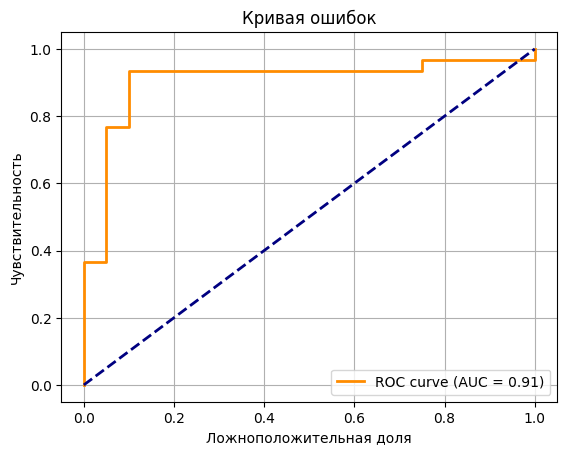

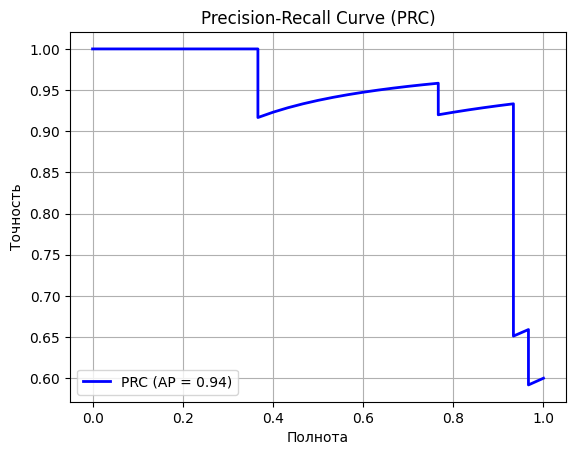

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  # Используем вероятности для класса 1
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Диагональная линия
plt.xlabel('Ложноположительная доля')
plt.ylabel('Чувствительность')
plt.title('Кривая ошибок')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('/content/drive/MyDrive/EEG/wavelet/roc.png')
plt.show()

# Построение Precision-Recall кривой
precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
average_precision = average_precision_score(y_true, y_pred[:, 1])

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (AP = {average_precision:.2f})')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='lower left')
plt.grid()
plt.savefig('/content/drive/MyDrive/EEG/wavelet/pcr.png')
plt.show()


In [ ]:
conf_matrix_path = os.path.join('/content/drive/MyDrive/EEG/wavelet', "confusion_matrix1.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')
plt.close()  # Закрыть график, чтобы избежать наложения
print(f"Матрица ошибок сохранена по пути: {conf_matrix_path}")

Матрица ошибок сохранена по пути: /content/drive/MyDrive/EEG/wavelet/confusion_matrix1.png


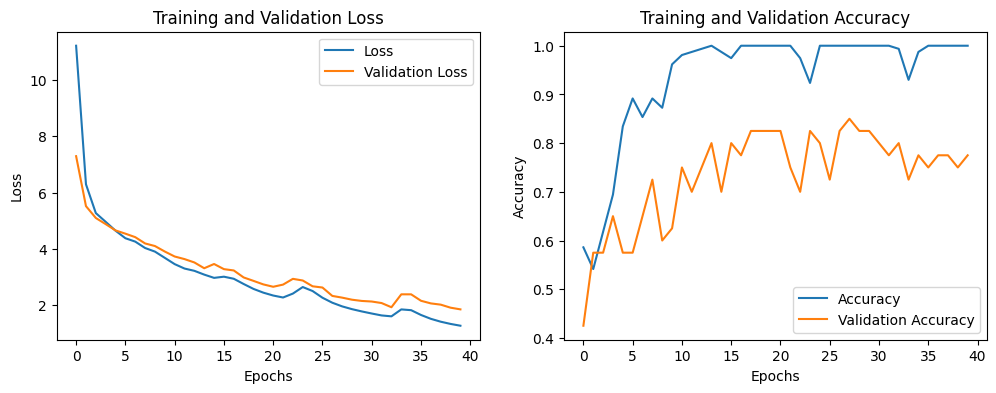

Матрица ошибок сохранена по пути: /content/drive/MyDrive/EEG/wavelet1/accurancy1.png


In [ ]:
# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('/content/drive/MyDrive/EEG/wavelet/acc.png', dpi=300, bbox_inches='tight')
plt.show()


plt.close()  # Закрыть график, чтобы избежать наложения
print(f"Матрица ошибок сохранена по пути: {accurancy_path}")

In [ ]:
# Сохранение весов
model.save_weights("model_weights.h5")

# Загрузка весов в ту же архитектуру модели
model.load_weights("model_weights.h5")

In [ ]:

# Загрузка данных и подготовка
image_dir = '/content/drive/MyDrive/EEG/wavelet'  # Путь к директории с изображениями
X, y = load_images(image_dir)
# Масштабирование данных и изменение размерности для нейронной сети
X/=255
# Преобразование меток в one-hot encoding
label_mapping = {'Healthy': 0, 'Seizure': 1}
y = np.array([label_mapping[label] for label in y])
y = to_categorical(y, num_classes=2)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели CNN-LSTM
def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # CNN layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(MaxPooling2D((2, 2)))

    # Увеличение количества dropout для уменьшения переобучения
    model.add(Dropout(0.6))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Flatten and LSTM layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Reshape((1, -1)))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(100))
    model.add(Dropout(0.5))

    # Fully connected layers
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # 3 класса для классификации

    # Компиляция модели
    # Компиляция модели с использованием правильного аргумента 'learning_rate'
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


    return model

# Инициализация модели
input_shape = (64, 64, 4)  # Изображения 64x64 с 3 каналами (RGB)
model = create_cnn_lstm_model(input_shape)
model.summary()

# Обучение модели

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# Преобразование меток обратно из one-hot encoding в одномерный массив меток
y_train_classes = np.argmax(y_train, axis=1)

# Вычисление весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Преобразование class_weights в словарь, так как model.fit ожидает словарь
class_weights_dict = dict(enumerate(class_weights))

# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, class_weight=class_weights_dict)
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Печать результатов оценки
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))

# Построение матрицы ошибок
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# @title Текст заголовка по умолчанию
# Инициализация модели
input_shape = (64, 64, 4)
model = create_cnn_lstm_model(input_shape)
model.summary()

# Обучение модели
y_train_classes = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights = dict(enumerate(class_weights))
history = model.fit(X_train, y_train, epochs=5, batch_size=8, validation_split=0.2)

# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Печать результатов оценки
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))


NameError: name 'create_cnn_lstm_model' is not defined

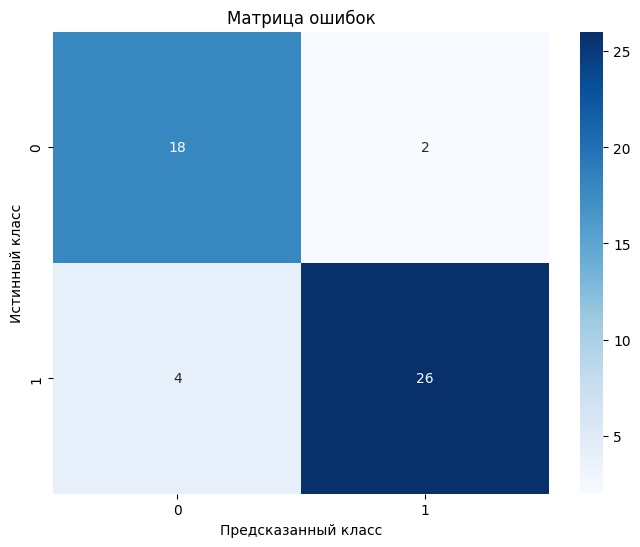

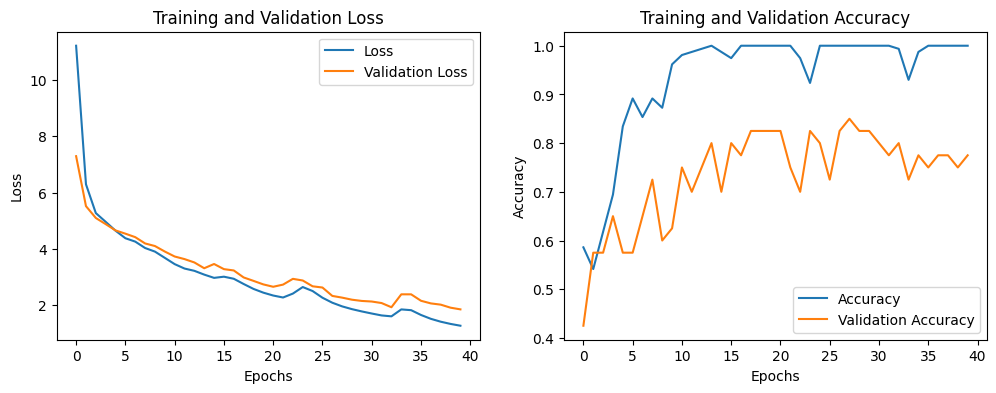

In [ ]:
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_true, y_pred_classes)
# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.savefig('/content/drive/MyDrive/EEG/wavelet/confusion.png', dpi=300, bbox_inches='tight')
plt.show()
# Визуализация процесса обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()